In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: marcodia
"""
import numpy as np
import random
import xarray as xr
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys
import os 

import network_arch as network
import metrics
import plot
import settings

import cftime
import matplotlib.pyplot as plt
import nc_time_axis

import matplotlib.lines as mlines


2023-05-30 15:48:38.696532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


importing Jupyter notebook from network_arch.ipynb
importing Jupyter notebook from metrics.ipynb
importing Jupyter notebook from plot.ipynb
importing Jupyter notebook from settings.ipynb


## Overall Assessment of Trained Models

In [3]:
running_window_yr = 10 #running mean
days_per_annualszn = 30+31+31+28 #(Nov-Feb)
running_window = running_window_yr * days_per_annualszn
array_size = 100 - running_window_yr
num_experiments = 10
num_seeds = 10 

timeplot = np.arange(1850,1950)
timeplot = timeplot[running_window_yr:(len(timeplot))]

ind = 0 
exp_num = 1

In [4]:
# Create Zeros Arrays
accuracy_trained_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
overall_accuracy_all_trained1 = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])
acc_v_conf_test1 = xr.DataArray(np.zeros([num_experiments,num_seeds,20]),dims = ['experiment','seed','conf_ints'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('conf_ints',np.arange(0,20))])
acc_v_conf_val1 = xr.DataArray(np.zeros([num_experiments,num_seeds,20]),dims = ['experiment','seed','conf_ints'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('conf_ints',np.arange(0,20))])

acc_v_conf_test2 = xr.DataArray(np.zeros([num_experiments,num_seeds,20]),dims = ['experiment','seed','conf_ints'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('conf_ints',np.arange(0,20))])
acc_v_conf_val2 = xr.DataArray(np.zeros([num_experiments,num_seeds,20]),dims = ['experiment','seed','conf_ints'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('conf_ints',np.arange(0,20))])

acc_v_conf_test3 = xr.DataArray(np.zeros([num_experiments,num_seeds,20]),dims = ['experiment','seed','conf_ints'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('conf_ints',np.arange(0,20))])
acc_v_conf_val3 = xr.DataArray(np.zeros([num_experiments,num_seeds,20]),dims = ['experiment','seed','conf_ints'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('conf_ints',np.arange(0,20))])



In [5]:
for sub_exp in np.arange(exp_num*100,exp_num*100+10):
    EXPERIMENT = EXPERIMENT NAME #need to name from settings file

    Xdata_folder = X_DATA #data folder with x-data
    Ydata_folder = Y_DATA #data folder with y-data

    ddir_X = DIRECTORY_X
    ddir_Y = DIRECTORY_Y
    ddir_in = DIRECTORY_IN
    ddir_out = DIRECTORY_OUT 
    
    params = settings.get_settings(EXPERIMENT)

    PREDICTOR_VAR  = params['PREDICTOR_VAR']           
    PREDICTAND_VAR = params['PREDICTAND_VAR']              
    REGION_TOR     = params['REGION_TOR']          
    REGION_TAND    = params['REGION_TAND']            
    training_ens   = params['training_ens']            
    validation_ens = params['validation_ens']           
    testing_ens    = params['testing_ens']           
    train_list     = params['train_list']           
    lead           = params['lead']            
    days_average   = params['days_average']            
    GLOBAL_SEED    = params['GLOBAL_SEED']            
    HIDDENS        = params['HIDDENS']          
    DROPOUT        = params['DROPOUT']            
    RIDGE1         = params['RIDGE1']                    
    LR_INIT        = params['LR_INIT']
    BATCH_SIZE     = params['BATCH_SIZE']           
    RANDOM_SEED    = params['RANDOM_SEED']            
    act_fun        = params['act_fun']            
    N_EPOCHS       = params['N_EPOCHS']           
    PATIENCE       = params['PATIENCE']   
    
    #>>>>>SET UP <<<<<<<<<<<<<<<
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.compat.v1.random.set_random_seed(GLOBAL_SEED)

    #Below files were created in calculate_testdata_acc_conf.ipynb 
    
    ind2= 0 
    for SEED in RANDOM_SEED:
        if ind2 < num_experiments:
            accuracy_trained_runavg[ind,ind2,:] = xr.open_dataarray(ddir_in+'accuracy_testdata_'+str(running_window_yr)+'yr_runavg_exp'+EXPERIMENT[-3:]+'_seed'+str(SEED)+'.nc')
            overall_accuracy_all_trained1[ind,:] = xr.open_dataarray(ddir_in+'overall_accuracy_testdata'+'_exp'+EXPERIMENT[-3:]+'_allseeds'+'.nc')
            acc_v_conf_test1[ind,:,:] = xr.open_dataarray(ddir_in+'confidence_vs_accuracy_TESTING_'+EXPERIMENT[-3:]+'_allseeds.nc')
            acc_v_conf_val1[ind,:,:] = xr.open_dataarray(ddir_in+'confidence_vs_accuracy_VALIDATION_'+EXPERIMENT[-3:]+'_allseeds.nc')
            ind2 = ind2+1
    ind = ind+1  
    
overall_accuracy_all_trained1 = overall_accuracy_all_trained1*100


In [6]:
#Reorder so test ensemble members are in correct order for plotting
overall_accuracy_all_trained1['experiment']= overall_accuracy_all_trained1.experiment-1 

overall_accuracy_all_reorder1 = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])
overall_accuracy_all_reorder1[0:9,:] = overall_accuracy_all_trained1[1:10,:]
overall_accuracy_all_reorder1[9,:] = overall_accuracy_all_trained1[0,:]


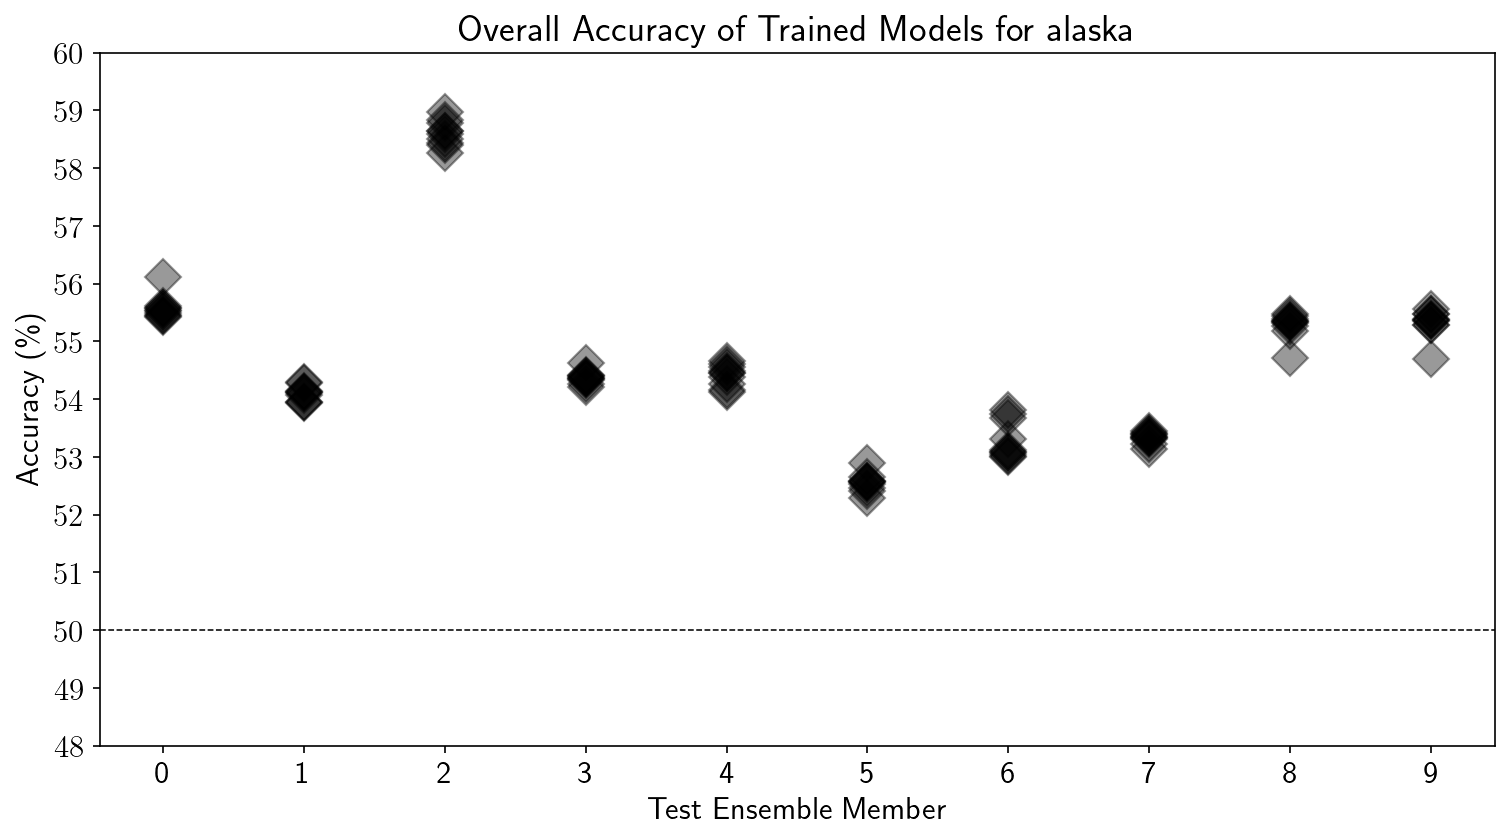

In [8]:
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
#Plot Overall Accuracy of Each Test Member
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

#Plot not used in paper; these are the accuracies spread out by ensemble member

fig, (ax1) = plt.subplots(1, figsize=(12,6))
ax1.plot(overall_accuracy_all_reorder1.experiment,overall_accuracy_all_reorder1, 'D', color = 'black', markeredgecolor='black', markeredgewidth=1,\
          markersize=12, alpha = 0.4)

ax1.set(xticks=(np.arange(0,10,step=1)))
ax1.set(xlabel = 'Test Ensemble Member')
ax1.set(ylabel = 'Accuracy (\%)')
ax1.set(yticks=(np.arange(48,61,step=1)))
ax1.set(xticklabels=['0','1','2','3','4','5','6','7','8','9'])

ax1.set(title='Overall Accuracy of Trained Models for '+REGION_TAND)

ax1.axhline(y=50, color='black', linestyle='--', linewidth=0.75)

## Put all Experiments into 1 plot

#### Region #2 analyzed

In [9]:
exp_num = 4
ind= 0
overall_accuracy_all_trained2 = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])

for sub_exp in np.arange(exp_num*100,exp_num*100+10):
    EXPERIMENT = EXPERIMENT NAME #need to name from settings file

    Xdata_folder = X_DATA #data folder with x-data
    Ydata_folder = Y_DATA #data folder with y-data

    ddir_X = DIRECTORY_X
    ddir_Y = DIRECTORY_Y
    ddir_in = DIRECTORY_IN
    ddir_out = DIRECTORY_OUT 
    
    params = settings.get_settings(EXPERIMENT)

    PREDICTOR_VAR  = params['PREDICTOR_VAR']           
    PREDICTAND_VAR = params['PREDICTAND_VAR']              
    REGION_TOR     = params['REGION_TOR']          
    REGION_TAND    = params['REGION_TAND']            
    training_ens   = params['training_ens']            
    validation_ens = params['validation_ens']           
    testing_ens    = params['testing_ens']           
    train_list     = params['train_list']           
    lead           = params['lead']            
    days_average   = params['days_average']            
    GLOBAL_SEED    = params['GLOBAL_SEED']            
    HIDDENS        = params['HIDDENS']          
    DROPOUT        = params['DROPOUT']            
    RIDGE1         = params['RIDGE1']                    
    LR_INIT        = params['LR_INIT']
    BATCH_SIZE     = params['BATCH_SIZE']           
    RANDOM_SEED    = params['RANDOM_SEED']            
    act_fun        = params['act_fun']            
    N_EPOCHS       = params['N_EPOCHS']           
    PATIENCE       = params['PATIENCE']   
    
    #>>>>>SET UP <<<<<<<<<<<<<<<
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.compat.v1.random.set_random_seed(GLOBAL_SEED)

    ind2= 0 
    for SEED in RANDOM_SEED:
        if ind2 < num_experiments:
            overall_accuracy_all_trained2[ind,:] = xr.open_dataarray(ddir_in+'overall_accuracy_testdata'+'_exp'+EXPERIMENT[-3:]+'_allseeds'+'.nc')
            acc_v_conf_test2[ind,:,:] = xr.open_dataarray(ddir_in+'confidence_vs_accuracy_TESTING_'+EXPERIMENT[-3:]+'_allseeds.nc')
            acc_v_conf_val2[ind,:,:] = xr.open_dataarray(ddir_in+'confidence_vs_accuracy_VALIDATION_'+EXPERIMENT[-3:]+'_allseeds.nc')
            ind2 = ind2+1
    ind = ind+1  
    
overall_accuracy_all_trained2 = overall_accuracy_all_trained2*100

#### Region #3 analyzed

In [10]:
exp_num = 5
ind= 0
overall_accuracy_all_trained3 = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])

for sub_exp in np.arange(exp_num*100,exp_num*100+10):
    EXPERIMENT = EXPERIMENT NAME #need to name from settings file

    Xdata_folder = X_DATA #data folder with x-data
    Ydata_folder = Y_DATA #data folder with y-data

    ddir_X = DIRECTORY_X
    ddir_Y = DIRECTORY_Y
    ddir_in = DIRECTORY_IN
    ddir_out = DIRECTORY_OUT 
    
    params = settings.get_settings(EXPERIMENT)

    PREDICTOR_VAR  = params['PREDICTOR_VAR']           
    PREDICTAND_VAR = params['PREDICTAND_VAR']              
    REGION_TOR     = params['REGION_TOR']          
    REGION_TAND    = params['REGION_TAND']            
    training_ens   = params['training_ens']            
    validation_ens = params['validation_ens']           
    testing_ens    = params['testing_ens']           
    train_list     = params['train_list']           
    lead           = params['lead']            
    days_average   = params['days_average']            
    GLOBAL_SEED    = params['GLOBAL_SEED']            
    HIDDENS        = params['HIDDENS']          
    DROPOUT        = params['DROPOUT']            
    RIDGE1         = params['RIDGE1']                    
    LR_INIT        = params['LR_INIT']
    BATCH_SIZE     = params['BATCH_SIZE']           
    RANDOM_SEED    = params['RANDOM_SEED']            
    act_fun        = params['act_fun']            
    N_EPOCHS       = params['N_EPOCHS']           
    PATIENCE       = params['PATIENCE']   
    
    #>>>>>SET UP <<<<<<<<<<<<<<<
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.compat.v1.random.set_random_seed(GLOBAL_SEED)

    ind2= 0 
    for SEED in RANDOM_SEED:
        if ind2 < num_experiments:
            overall_accuracy_all_trained3[ind,:] = xr.open_dataarray(ddir_in+'overall_accuracy_testdata'+'_exp'+EXPERIMENT[-3:]+'_allseeds'+'.nc')
            acc_v_conf_test3[ind,:,:] = xr.open_dataarray(ddir_in+'confidence_vs_accuracy_TESTING_'+EXPERIMENT[-3:]+'_allseeds.nc')
            acc_v_conf_val3[ind,:,:] = xr.open_dataarray(ddir_in+'confidence_vs_accuracy_VALIDATION_'+EXPERIMENT[-3:]+'_allseeds.nc')
            ind2 = ind2+1
    ind = ind+1  
    
overall_accuracy_all_trained3 = overall_accuracy_all_trained3*100

In [11]:
#Reorder so test ensemble members are in correct order
overall_accuracy_all_trained2['experiment']= overall_accuracy_all_trained2.experiment-1 

overall_accuracy_all_reorder2 = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])
overall_accuracy_all_reorder2[0:9,:] = overall_accuracy_all_trained2[1:10,:]
overall_accuracy_all_reorder2[9,:] = overall_accuracy_all_trained2[0,:]

#Reorder so test ensemble members are in correct order
overall_accuracy_all_trained3['experiment']= overall_accuracy_all_trained3.experiment-1 

overall_accuracy_all_reorder3 = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])
overall_accuracy_all_reorder3[0:9,:] = overall_accuracy_all_trained3[1:10,:]
overall_accuracy_all_reorder3[9,:] = overall_accuracy_all_trained3[0,:]

In [12]:
avg_overall_accuracy_all_reorder1 = np.mean(overall_accuracy_all_reorder1,axis=1)
avg_overall_accuracy_all_reorder1.shape
temp1 = np.resize(avg_overall_accuracy_all_reorder1,([10,1]))
acc_seeds_all1 = np.transpose(temp1)
overall_accuracy_all_reorder1_all = np.resize(overall_accuracy_all_reorder1,([1,100]))

avg_overall_accuracy_all_reorder2 = np.mean(overall_accuracy_all_reorder2,axis=1)
avg_overall_accuracy_all_reorder2.shape
temp2 = np.resize(avg_overall_accuracy_all_reorder2,([10,1]))
acc_seeds_all2 = np.transpose(temp2)
overall_accuracy_all_reorder2_all = np.resize(overall_accuracy_all_reorder2,([1,100]))

avg_overall_accuracy_all_reorder3 = np.mean(overall_accuracy_all_reorder3,axis=1)
avg_overall_accuracy_all_reorder3.shape
temp3 = np.resize(avg_overall_accuracy_all_reorder3,([10,1]))
acc_seeds_all3 = np.transpose(temp3)

overall_accuracy_all_reorder3_all = np.resize(overall_accuracy_all_reorder3,([1,100]))

In [13]:
array = np.arange(0,12,1)

untrained1 =  xr.open_dataarray(untrained_network_data)  #output from a model that was untrained i.e. randomly initialized but never updated
untrained1 = np.resize(untrained1,([10,1]))
untrained1 = untrained1*100
untrained1 = np.transpose(untrained1)

untrained2 =  xr.open_dataarray(untrained_network_data)
untrained2 = np.resize(untrained2,([10,1]))
untrained2 = untrained2*100
untrained2 = np.transpose(untrained2)

untrained3 =  xr.open_dataarray(untrained_network_data)
untrained3 = np.resize(untrained3,([10,1]))
untrained3 = untrained3*100
untrained3 = np.transpose(untrained3)

In [14]:
conf_int = 16

acc_v_conf_test1_avg = np.mean(acc_v_conf_test1,axis=1)[:,conf_int]
acc_v_conf_test1_avg = np.resize(acc_v_conf_test1_avg,([10,1]))
acc_v_conf_test1_plot = np.transpose(acc_v_conf_test1_avg)

acc_v_conf_test2_avg = np.mean(acc_v_conf_test2,axis=1)[:,conf_int]
acc_v_conf_test2_avg = np.resize(acc_v_conf_test2_avg,([10,1]))
acc_v_conf_test2_plot = np.transpose(acc_v_conf_test2_avg)

acc_v_conf_test3_avg = np.mean(acc_v_conf_test3,axis=1)[:,conf_int]
acc_v_conf_test3_avg = np.resize(acc_v_conf_test3_avg,([10,1]))
acc_v_conf_test3_plot = np.transpose(acc_v_conf_test3_avg)

In [39]:
untrained_acc_v_conf1 = xr.open_dataarray('/Users/marcodia/Research/Data/processed_fields/Week_45/exp_1/untrained_model/101confidence_vs_accuracy_TESTING_101_allseeds.nc')
untrained_acc_v_conf2 = xr.open_dataarray('/Users/marcodia/Research/Data/processed_fields/Week_45/exp_4/untrained_model/101confidence_vs_accuracy_TESTING_401_allseeds.nc')
untrained_acc_v_conf3 = xr.open_dataarray('/Users/marcodia/Research/Data/processed_fields/Week_45/exp_5/untrained_model/101confidence_vs_accuracy_TESTING_501_allseeds.nc')


In [40]:
UT_acc_v_conf_test1_avg = untrained_acc_v_conf1[:,conf_int]
UT_acc_v_conf_test1_avg = np.resize(UT_acc_v_conf_test1_avg,([10,1]))
UT_acc_v_conf_test1_avg_plot = np.transpose(UT_acc_v_conf_test1_avg)

UT_acc_v_conf_test2_avg = untrained_acc_v_conf2[:,conf_int]
UT_acc_v_conf_test2_avg = np.resize(UT_acc_v_conf_test2_avg,([10,1]))
UT_acc_v_conf_test2_avg_plot = np.transpose(UT_acc_v_conf_test2_avg)

UT_acc_v_conf_test3_avg = untrained_acc_v_conf3[:,conf_int]
UT_acc_v_conf_test3_avg = np.resize(UT_acc_v_conf_test3_avg,([10,1]))
UT_acc_v_conf_test3_avg_plot = np.transpose(UT_acc_v_conf_test3_avg)

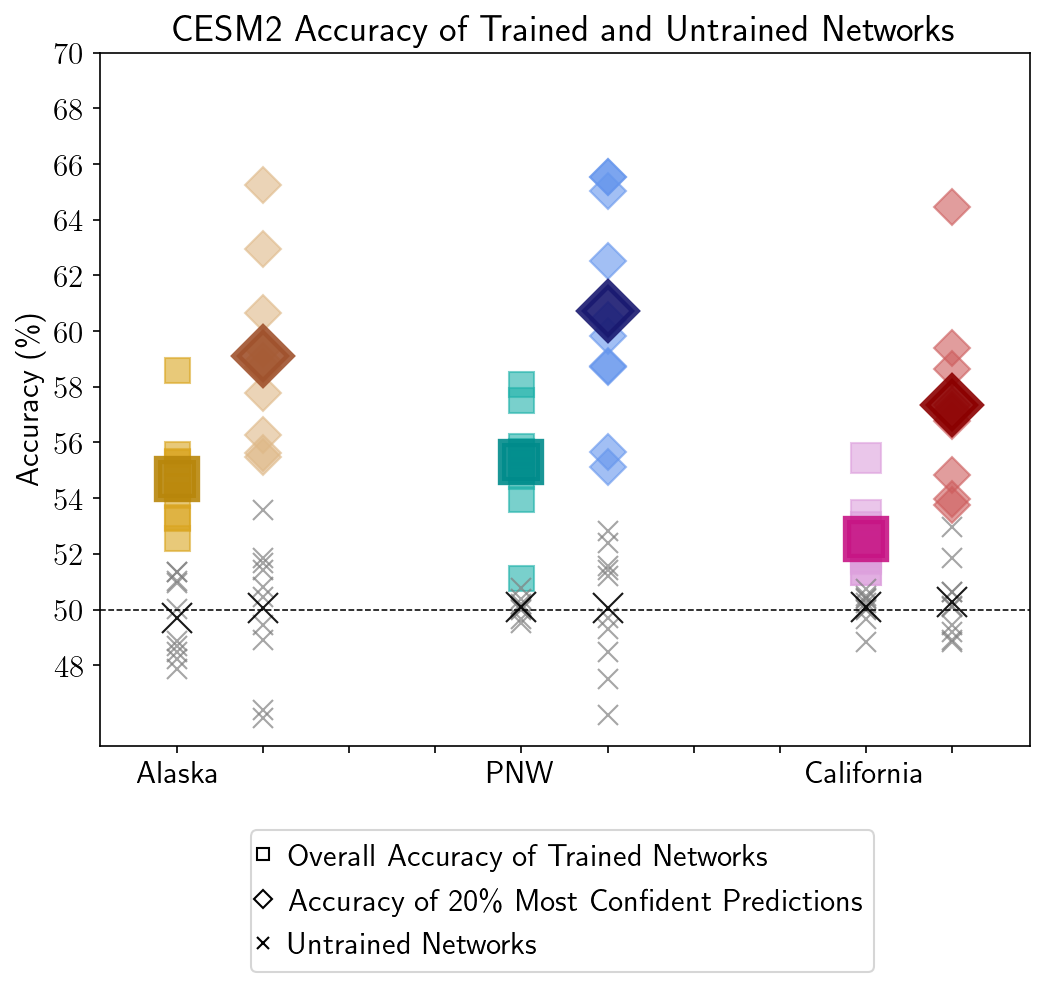

In [41]:
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
#Plot Overall Accuracy of Each Test Member
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

fig, (ax1) = plt.subplots(1, figsize=(8,6))

#ax1.plot(array[0],overall_accuracy_all_reorder1_all, 'D', color = 'gray', markeredgecolor='gray', markeredgewidth=1,markersize=8, alpha = 0.3)
ax1.plot(array[0],acc_seeds_all1, 's', color = 'goldenrod', markeredgecolor='goldenrod', markeredgewidth=1,markersize=12, alpha = 0.6)
ax1.plot(array[0],np.mean(acc_seeds_all1), 's', color = 'darkgoldenrod', markeredgecolor='darkgoldenrod', markeredgewidth=4,markersize=18, alpha = 0.9, label='Alaska (trained model)')
ax1.plot(array[0],untrained1, 'x', color = 'slategray', markeredgecolor='gray', markersize=10, alpha = 0.7)
ax1.plot(array[0],np.mean(untrained1), 'x', color = 'black', markeredgecolor='black', markersize=14, alpha = 0.9)
ax1.plot(array[1],acc_v_conf_test1_plot, 'D', color = 'burlywood', markeredgecolor='burlywood', markeredgewidth=1,markersize=12, alpha = 0.6)
ax1.plot(array[1],np.mean(acc_v_conf_test1_avg,axis=0), 'D', color = 'sienna', markeredgecolor='sienna', markeredgewidth=4,markersize=18, alpha = 0.9)

ax1.plot(array[1],UT_acc_v_conf_test1_avg_plot, 'x', color = 'slategray', markeredgecolor='gray', markersize=10, alpha = 0.7)
ax1.plot(array[1],np.mean(UT_acc_v_conf_test1_avg_plot), 'x', color = 'black', markeredgecolor='black', markersize=14, alpha = 0.9)

# ax1.plot(array[1],overall_accuracy_all_reorder2_all, 'D', color = 'gray', markeredgecolor='gray', markeredgewidth=1,markersize=8, alpha = 0.3)
# ax1.plot(array[1],acc_seeds_all2, 'D', color = 'blue', markeredgecolor='blue', markeredgewidth=1,markersize=14, alpha = 0.6)
# ax1.plot(array[1],untrained2, 'x', color = 'slategray', markeredgecolor='gray', markersize=10, alpha = 0.7)

ax1.plot(array[4],acc_seeds_all2, 's', color = 'lightseagreen', markeredgecolor='lightseagreen', markeredgewidth=1,markersize=12, alpha = 0.6)
ax1.plot(array[4],np.mean(acc_seeds_all2), 's', color = 'darkcyan', markeredgecolor='darkcyan', markeredgewidth=4,markersize=18, alpha = 0.9, label='Pacific Northwest (trained model)')
ax1.plot(array[4],untrained2, 'x', color = 'slategray', markeredgecolor='gray', markersize=10, alpha = 0.7)
ax1.plot(array[4],np.mean(untrained2), 'x', color = 'black', markeredgecolor='black', markersize=14, alpha = 0.9)
ax1.plot(array[5],acc_v_conf_test2_plot, 'D', color = 'cornflowerblue', markeredgecolor='cornflowerblue', markeredgewidth=1,markersize=12, alpha = 0.6)
ax1.plot(array[5],np.mean(acc_v_conf_test2_avg,axis=0), 'D', color = 'midnightblue', markeredgecolor='midnightblue', markeredgewidth=4,markersize=18, alpha = 0.9)
ax1.plot(array[5],UT_acc_v_conf_test2_avg_plot, 'x', color = 'slategray', markeredgecolor='gray', markersize=10, alpha = 0.7)
ax1.plot(array[5],np.mean(UT_acc_v_conf_test2_avg_plot), 'x', color = 'black', markeredgecolor='black', markersize=14, alpha = 0.9)


#ax1.plot(array[2],overall_accuracy_all_reorder3_all, 'D', color = 'gray', markeredgecolor='gray', markeredgewidth=1,markersize=8, alpha = 0.3)
ax1.plot(array[8],acc_seeds_all3, 's', color = 'plum', markeredgecolor='plum', markeredgewidth=1,markersize=14, alpha = 0.6)
ax1.plot(array[8],np.mean(acc_seeds_all3), 's', color = 'mediumvioletred', markeredgecolor='mediumvioletred', markeredgewidth=4,markersize=18, alpha = 0.9, label='California (trained model)')
ax1.plot(array[8],untrained3, 'x', color = 'slategray', markeredgecolor='gray', markersize=10, alpha = 0.7)
ax1.plot(array[8],np.mean(untrained3), 'x', color = 'black', markeredgecolor='black', markersize=14, alpha = 0.9,label='Untrained Model')
ax1.plot(array[9],acc_v_conf_test3_plot, 'D', color = 'indianred', markeredgecolor='indianred', markeredgewidth=1,markersize=12, alpha = 0.6)
ax1.plot(array[9],np.mean(acc_v_conf_test3_avg,axis=0), 'D', color = 'darkred', markeredgecolor='darkred', markeredgewidth=4,markersize=18, alpha = 0.9)
ax1.plot(array[9],UT_acc_v_conf_test3_avg_plot, 'x', color = 'slategray', markeredgecolor='gray', markersize=10, alpha = 0.7)
ax1.plot(array[9],np.mean(UT_acc_v_conf_test3_avg_plot), 'x', color = 'black', markeredgecolor='black', markersize=14, alpha = 0.9)



ax1.set(xticks=(np.arange(0,12,step=1)))
#ax1.set(xlabel = 'Test Ensemble Member')
ax1.set(ylabel = 'Accuracy (\%)')
ax1.set(yticks=(np.arange(48,71,step=2)))
ax1.set(xticklabels=['Alaska','','','','PNW','','','','California','','',''])

ax1.set(title='CESM2 Accuracy of Trained and Untrained Networks')

ax1.axhline(y=50, color='black', linestyle='--', linewidth=0.75)
plt.margins(x=0.1)
#plt.legend(loc='center right',ncol=1, bbox_to_anchor=(1.2, 0.3, 0.5, 0.5),borderpad=1.5,labelspacing = 1.6)

one = mlines.Line2D([], [], color='white', marker='s', markeredgecolor='black', label='Overall Accuracy of Trained Networks')
two = mlines.Line2D([], [], color='white', marker='D', markeredgecolor='black', label='Accuracy of 20\% Most Confident Predictions')
three = mlines.Line2D([], [], color='mediumseagreen', marker='D',  label='California (trained model)')
four = mlines.Line2D([], [], color='gray', marker='x', markeredgecolor='black', label='Untrained Networks')
plt.legend(handles=[one,two,four],handlelength=0, ncol=1, bbox_to_anchor=(0.85, -0.1)) 
#plt.legend(handles=[one,four],handlelength=0, ncol=1, bbox_to_anchor=(0.85, -0.1))  

#plt.savefig(ddir_figs+REGION_TAND+'_accuracy_trained_allmodels_allseeds.png', format='png',dpi=150)

## Accuracy v Confidence

In [70]:
acc_v_conf_val = acc_v_conf_val1
acc_v_conf_test = acc_v_conf_test1

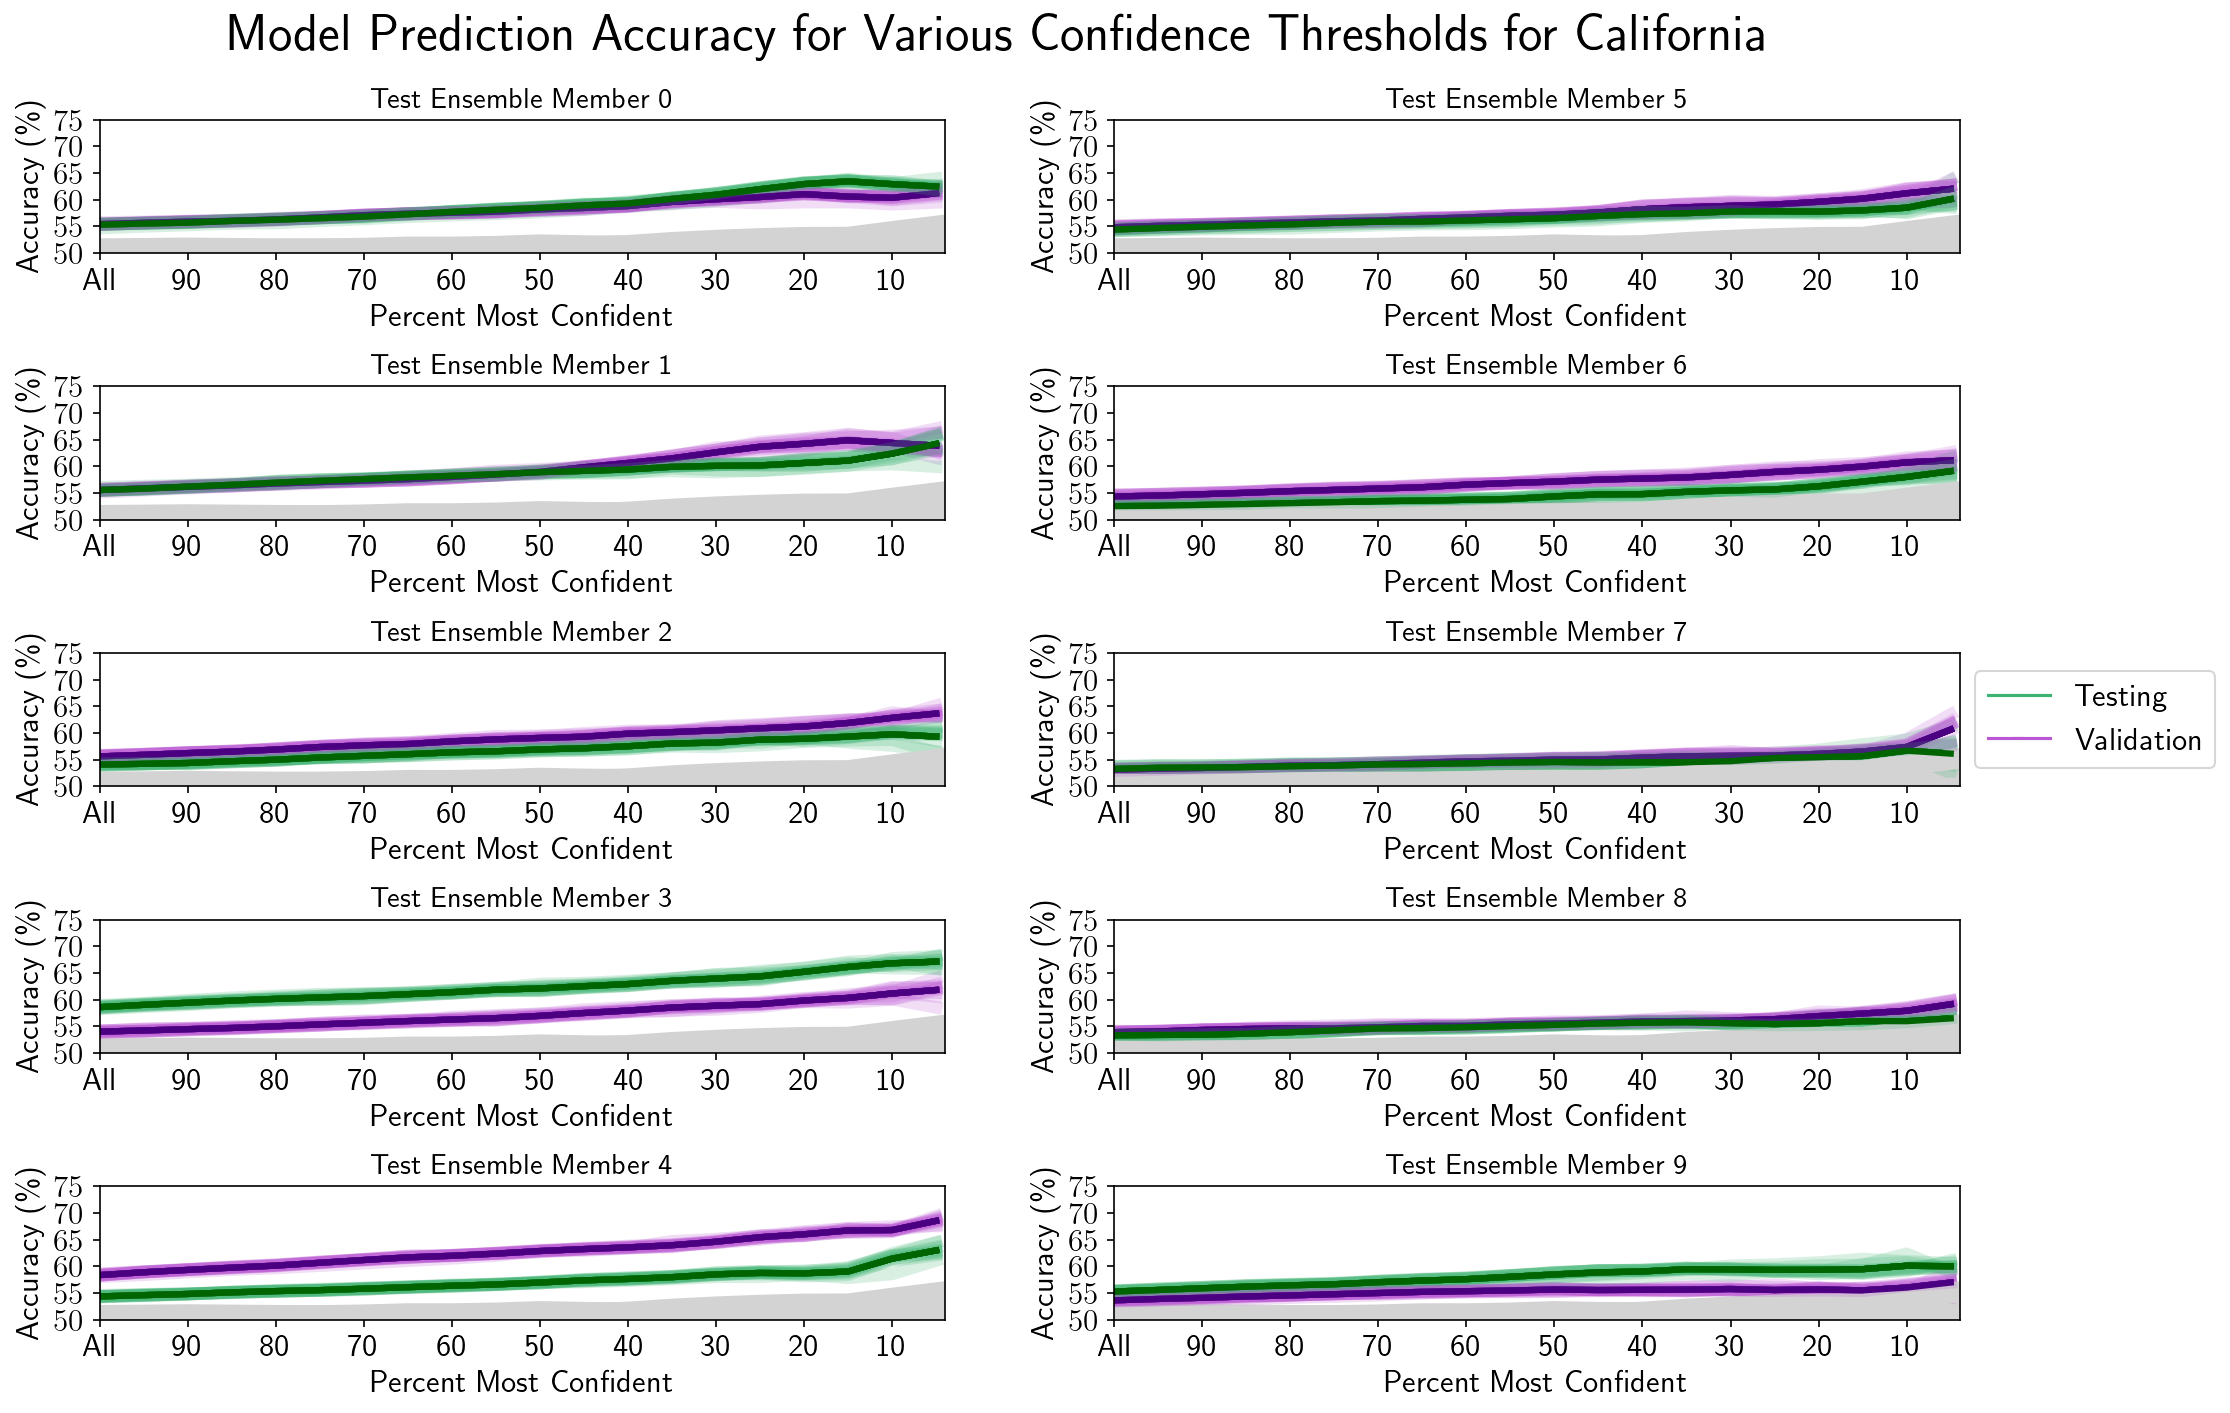

In [71]:
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
#Plot Accuracy vs Confidence for Validation and Testing

fig, ax = plt.subplots(5,2, figsize=(16,10)) #sharex = True

for exp in np.arange(0,10):

    for SEED in np.arange(0,10):
        if exp < 5:
            ax[exp, 0].plot(np.arange(0,100,5), acc_v_conf_val[exp,SEED,:], color = 'mediumorchid', linewidth=6, alpha=0.2)
            ax[exp, 0].plot(np.arange(0,100,5), np.mean(acc_v_conf_val,axis=1)[exp,:], color = 'indigo', linewidth=3)
            ax[exp, 0].plot(np.arange(0,100,5), acc_v_conf_test[exp,SEED,:], color = 'mediumseagreen', linewidth=6, alpha=0.2)
            ax[exp, 0].plot(np.arange(0,100,5), np.mean(acc_v_conf_test,axis=1)[exp,:], color = 'darkgreen', linewidth=3)
            
            ax[exp, 0].plot(np.arange(0,100,5), untrained_acc_v_conf3[SEED,:], color = 'lightgray', linewidth=10)            
            #ax[exp, 0].set(xlim=(100,0)
            ax[exp, 0].set(xticks=(np.arange(0,100,step=10)))
            ax[exp, 0].set(xlim=(0,96))
            ax[exp, 0].set(ylim=(50,75))
            ax[exp, 0].set(yticks=(np.arange(50,80, step=5)))
            ax[exp, 0].set(xticklabels = ['All', '90', '80', '70', '60', '50', '40', '30', '20', '10'])
            ax[exp, 0].set_title('Test Ensemble Member '+str(exp),fontsize =14)
            ax[exp, 0].set(xlabel='Percent Most Confident')
            ax[exp, 0].set(ylabel='Accuracy (\%)')
        if exp >= 5:
            ax[exp-5, 1].plot(np.arange(0,100,5), acc_v_conf_val[exp,SEED,:], color = 'mediumorchid', linewidth=6, alpha=0.2)
            ax[exp-5, 1].plot(np.arange(0,100,5), np.mean(acc_v_conf_val,axis=1)[exp,:], color = 'indigo', linewidth=3)
            ax[exp-5, 1].plot(np.arange(0,100,5), acc_v_conf_test[exp,SEED,:], color = 'mediumseagreen', linewidth=6, alpha=0.2)
            ax[exp-5, 1].plot(np.arange(0,100,5), np.mean(acc_v_conf_test,axis=1)[exp,:], color = 'darkgreen', linewidth=3)
            ax[exp-5, 1].plot(np.arange(0,100,5), untrained_acc_v_conf3[SEED,:], color = 'lightgray', linewidth=10) 
            ax[exp-5, 1].set(xticks=(np.arange(0,100,step=10)))
            ax[exp-5, 1].set(xlim=(0,96))
            ax[exp-5, 1].set(ylim=(50,75))
            ax[exp-5, 1].set(yticks=(np.arange(50,80, step=5)))
            ax[exp-5, 1].set(xticklabels = ['All', '90', '80', '70', '60', '50', '40', '30', '20', '10'])
            ax[exp-5, 1].set_title('Test Ensemble Member '+str(exp),fontsize =14)
            ax[exp-5, 1].set(xlabel='Percent Most Confident')
            ax[exp-5, 1].set(ylabel='Accuracy (\%)')

labels = ['Testing','Validation']            
fig.subplots_adjust(top=0.91, wspace = 0.2, hspace = 1.00)
#plt.suptitle(('Model Prediction Accuracy for Various Confidence Thresholds for '+REGION_TAND), fontsize='25')
plt.suptitle(('Model Prediction Accuracy for Various Confidence Thresholds for California'), fontsize='25')

one = mlines.Line2D([], [], color='mediumseagreen', marker='_',  label='Testing')
two = mlines.Line2D([], [], color='mediumorchid', marker='_', label='Validation')

plt.legend(handles=[one,two],loc='center left',ncol=1, bbox_to_anchor=(1, 4.5))  
#plt.savefig('/Users/marcodia/Research/lowfreq_S2S_project/figs_for_publication/acc_v_conf_'+REGION_TAND+'allexps.png', format = 'png')

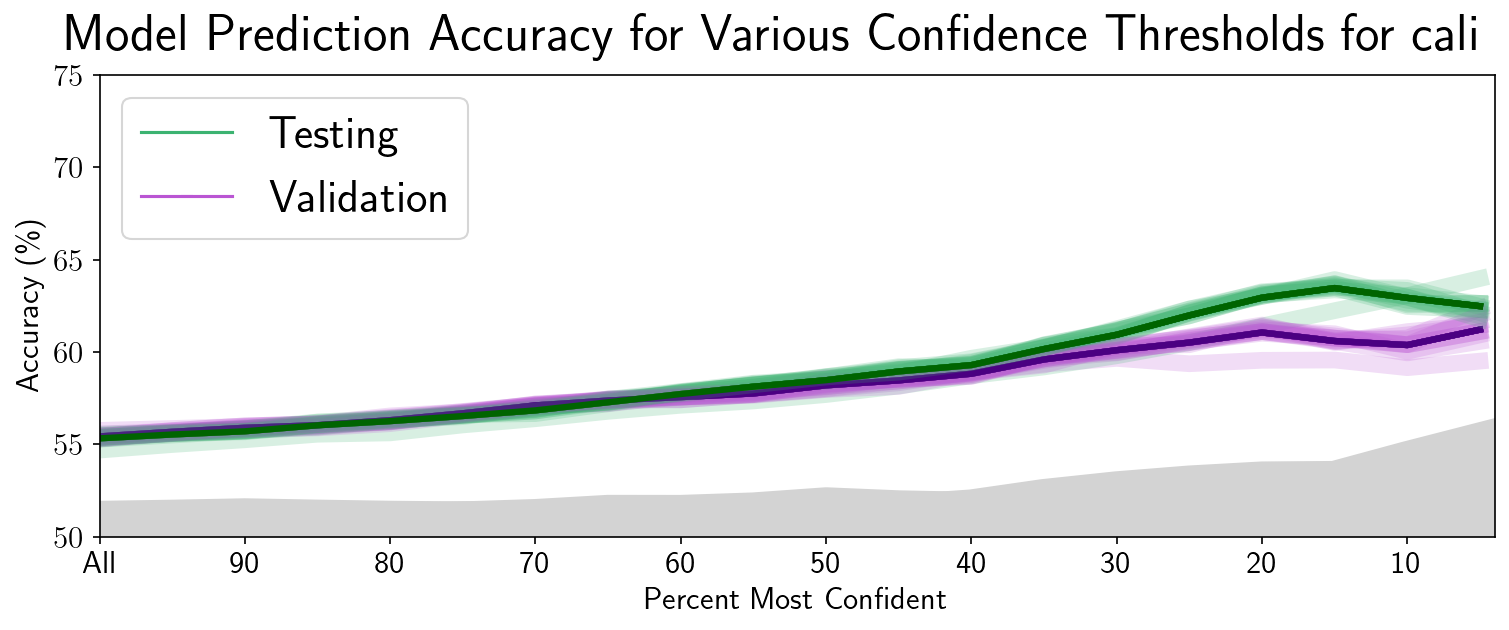

In [72]:
exp = 0 #choose 1 ensemble member to plot

fig, ax = plt.subplots(1,1, figsize=(12,4)) #sharex = True

for SEED in np.arange(0,10):
    ax.plot(np.arange(0,100,5), acc_v_conf_val[exp,SEED,:], color = 'mediumorchid', linewidth=8, alpha=0.2)
    ax.plot(np.arange(0,100,5), np.mean(acc_v_conf_val,axis=1)[exp,:], color = 'indigo', linewidth=3)
    ax.plot(np.arange(0,100,5), acc_v_conf_test[exp,SEED,:], color = 'mediumseagreen', linewidth=8, alpha=0.2)
    ax.plot(np.arange(0,100,5), np.mean(acc_v_conf_test,axis=1)[exp,:], color = 'darkgreen', linewidth=3)

    ax.plot(np.arange(0,100,5), untrained_acc_v_conf3[SEED,:], color = 'lightgray', linewidth=20)
    ax.plot(np.arange(0,100,5), untrained_acc_v_conf3[SEED,:]-2, color = 'lightgray', linewidth=20)
    ax.set(xticks=(np.arange(0,100,step=10)))
    ax.set(xlim=(0,96))
    ax.set(ylim=(50,75))
    ax.set(yticks=(np.arange(50,80, step=5)))
    ax.set(xticklabels = ['All', '90', '80', '70', '60', '50', '40', '30', '20', '10'])
    #ax.set_title('Test Ensemble Member '+str(exp),fontsize =14)
    ax.set(ylabel='Accuracy (\%)')
    ax.set(xlabel='Percent Most Confident')

labels = ['Testing','Validation']            
#fig.subplots_adjust(top=0.91, wspace = 0.2, hspace = 0.6)
plt.suptitle(('Model Prediction Accuracy for Various Confidence Thresholds for '+REGION_TAND), fontsize='25')
one = mlines.Line2D([], [], color='mediumseagreen', marker='_',  label='Testing')
two = mlines.Line2D([], [], color='mediumorchid', marker='_', label='Validation')

plt.legend(handles=[one,two],loc='upper left',ncol=1, fontsize=22)  
#plt.savefig('/Users/marcodia/Research/lowfreq_S2S_project/figs_for_publication/acc_v_conf_'+REGION_TAND+'allexps.png', format = 'png')

In [52]:
#Plot Highest Seed from all experiments for running average of accuracy 

# for exp in np.arange(0,10):
#     seed_winner_trained = np.argmax(np.array(overall_accuracy_all_trained[exp,:]))
#     #print(seed_winner_trained)
#     accuracy_seed_winner_trained[aexp,:] = accuracy_trained_runavg[exp,seed_winner_trained,:]
    
# for exp in np.arange(0,10):
#     seed_loser_trained = np.argmin(np.array(overall_accuracy_all_trained[exp,:]))
#     #print(seed_winner_trained)
#     accuracy_seed_loser_trained[exp,:] = accuracy_trained_runavg[exp,seed_loser_trained,:]

### Running Window of Accuracy (all predictions)

In [ ]:
#Reorder so test ensemble members are in correct order
accuracy_trained_runavg['experiment']= accuracy_trained_runavg.experiment-1 

accuracy_trained_runavg_reorder = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
accuracy_trained_runavg_reorder[0:9,:,:] = accuracy_trained_runavg[1:10,:,:]
accuracy_trained_runavg_reorder[9,:,:] = accuracy_trained_runavg[0,:,:]

#Plot all the Seeds from all Experiments 
fig, ax = plt.subplots(5,2, sharex= True, figsize=(16,10))

for exp in np.arange(0,10):

    for SEED in np.arange(0,10):
        if exp < 5:
            ax[exp, 0].plot(timeplot, accuracy_trained_runavg_reorder[exp,SEED,:], label='Seed '+str(RANDOM_SEED[SEED]))
            ax[exp, 0].set(xlim=(timeplot[0],timeplot[-1]+1))
            ax[exp, 0].set(xticks=(np.arange(timeplot[0],timeplot[-1]+5,step=10)))
            ax[exp, 0].set(ylim=(40,70))
            ax[exp, 0].set(yticks=(np.arange(40,75, step=10)))
            ax[exp, 0].set_title('Test Ensemble Member '+str(exp),fontsize =14)
            ax[exp, 0].set(ylabel='Accuracy (\%)')
            ax[exp, 0].axhline(y=50, color='black', linestyle='--', linewidth=0.75)
        if exp >= 5:
            ax[exp-5, 1].plot(timeplot, accuracy_trained_runavg_reorder[exp,SEED,:], label='Seed '+str(RANDOM_SEED[SEED]))
            ax[exp-5, 1].set(xlim=(timeplot[0],timeplot[-1]+1))
            ax[exp-5, 1].set(xticks=(np.arange(timeplot[0],timeplot[-1]+5,step=10)))
            ax[exp-5, 1].set(ylim=(40,70))
            ax[exp-5, 1].set(yticks=(np.arange(40,75, step=10)))
            ax[exp-5, 1].set_title('Test Ensemble Member '+str(exp),fontsize =14)
            ax[exp-5, 1].set_title('Test Ensemble Member '+str(exp-1),fontsize =14)
            ax[exp-5, 1].set(ylabel='Accuracy (\%)')
            ax[exp-5, 1].axhline(y=50, color='black', linestyle='--', linewidth=0.75)

fig.subplots_adjust(top=0.91, hspace= 0.4)
plt.suptitle((str(running_window_yr)+'-yr Running Window of Accuracy for '+REGION_TAND), fontsize='25')
plt.legend(loc='center left',ncol=1, bbox_to_anchor=(1, 3.0))

#plt.savefig(ddir_figs+'accuracy_testdata_timeseries_'+str(running_window_yr)+'yr_runavg_exp_'+REGION_TAND+'_allseeds.png', dpi = 150, format='png')

In [ ]:
#Plot just one ensemble member
fig, ax = plt.subplots(1, sharex= True, figsize=(12,6))


for SEED in np.arange(0,10):
    plt.plot(timeplot, accuracy_trained_runavg_reorder[0,SEED,:], label='Seed '+str(RANDOM_SEED[SEED]))
    ax.set(xlim=(timeplot[0],timeplot[-1]+1))
    ax.set(xticks=(np.arange(timeplot[0],timeplot[-1]+5,step=10)))
    ax.set(ylim=(40,90))
    ax.set(yticks=(np.arange(40,95, step=5)))
    ax.set_title('Test Ensemble Member 9',fontsize =14)
    ax.set(ylabel='Accuracy (\%)')